# Data Extraction and Combination

Notebook to perform tasks to extract, simplify, combine, and analyze data from several sources.

## Data Sources

- Land Area figures for New Hampshire: NH GRANIT system; compiled at [NH Office of Strategic Initiatives](https://www.nh.gov/osi/planning/services/gis/maps.htm), May 2021
- New Hampshire Political Boundaries at 1:24,000 Scale: [NH GRANIT system](https://granit.unh.edu/cgi-bin/nhsearch?dset=pb&#47;nh)
- New Hampshire Conservation/Public Lands at 1:24,000 Scale: [NH GRANIT system](https://www.granit.unh.edu/cgi-bin/nhsearch?dset=consnh&#47;nh)
    - [Interactive map](https://data-nhgranit.opendata.arcgis.com/datasets/new-hampshire-conservation-public-lands/explore?location=43.117182%2C-71.544725%2C13.00)

In [1]:
# Package imports
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import geemap

pd.set_option('max_columns', 50)

## Data Imports

In [15]:
# Import land area data
land_area = pd.read_csv('./data/NH-land-area-figures-consolidated.csv',
                        header=3)

In [16]:
land_area.head()

,County,Municipality,Total acres,Total sq. miles,Land acres,Land sq. miles,Water acres,Water sq. miles
0,Belknap,Alton,53230.5,83.17,40636.10,63.49,12594.40,19.68
1,Belknap,Barnstead,28758.7,44.94,27215.21,42.52,1543.49,2.41
2,Belknap,Belmont,20427.6,31.92,19190.38,29.98,1237.22,1.93
3,Belknap,Center Harbor,10394.4,16.24,8498.05,13.28,1896.35,2.96
4,Belknap,Gilford,34243.7,53.51,24786.22,38.73,9457.48,14.78


In [17]:
land_area.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259 entries, 0 to 258
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   County           259 non-null    object 
 1   Municipality     259 non-null    object 
 2   Total acres      259 non-null    float64
 3   Total sq. miles  259 non-null    float64
 4   Land acres       259 non-null    float64
 5   Land sq. miles   259 non-null    float64
 6   Water acres      259 non-null    float64
 7   Water sq. miles  259 non-null    float64
dtypes: float64(6), object(2)
memory usage: 16.3+ KB


In [19]:
total_areas = land_area.groupby(['County']).sum()
total_areas

,Total acres,Total sq. miles,Land acres,Land sq. miles,Water acres,Water sq. miles
County,,,,,,
Belknap,300786.19,469.98,256443.63,400.68,44342.57,69.28
Carroll,635817.97,993.47,595805.22,930.95,40012.76,62.52
Cheshire,466514.34,728.94,450805.97,704.39,15708.39,24.54
Coos,1171969.27,1831.21,1148425.31,1794.41,23543.98,36.77
Grafton,1119743.95,1749.59,1093489.36,1708.56,26254.63,41.02
Hillsborough,571152.78,892.46,555882.47,868.58,15270.34,23.85
Merrimack,611148.30,954.92,593770.15,927.73,17378.17,27.12
Rockingham,465182.48,726.86,445326.83,695.83,19855.68,31.01
Strafford,244860.75,382.60,233827.90,365.36,11032.86,17.23


In [20]:
# Import political boundaries (pb) data
pba_path = '../../NH_PoliticalBoundaries/GRANIT_20220220160347/pba.shp'  # Lines
pbp_path = '../../NH_PoliticalBoundaries/GRANIT_20220220160347/pbp.shp'  # Polygons

In [21]:
pb_lines = gpd.read_file(pba_path, driver='shapefile')

In [22]:
pb_lines.head()

,FNODE_,TNODE_,LPOLY_,RPOLY_,LENGTH,PB_,PB_ID,TYPE,geometry
0,3,1,1,2,74843.38,1,1,1,"LINESTRING (1063158.250 1002584.875, 1063233.0..."
1,1,2,1,2,83566.10,2,2,1,"LINESTRING (1102437.750 1003597.625, 1102581.7..."
2,4,3,1,2,33244.42,3,3,1,"LINESTRING (1043039.000 996290.125, 1043019.12..."
3,5,4,1,2,46482.84,4,4,1,"LINESTRING (1045191.375 966039.625, 1045218.87..."
4,6,5,1,2,57585.89,5,5,1,"LINESTRING (1027435.875 932679.000, 1027442.00..."


In [33]:
pb_lines.shape

(773, 9)

<AxesSubplot:>

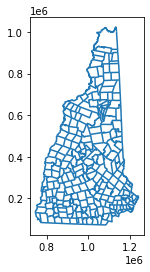

In [35]:
pb_lines.plot()

In [23]:
pb_poly = gpd.read_file(pbp_path, driver='shapefile')

In [24]:
pb_poly.head()

,FIPS,NAME,RPA,ACRES,COUNTY,geometry
0,7160,Pittsburg,1,186430.5,7,"POLYGON ((1063158.250 1002584.875, 1063233.000..."
1,7040,Clarksville,1,39915.8,7,"POLYGON ((1059756.000 928359.250, 1059898.250 ..."
2,7005,Atkinson & Gilmanton,1,12351.3,7,"POLYGON ((1111451.250 916720.625, 1111518.250 ..."
3,7190,Stewartstown,1,30019.1,7,"POLYGON ((1019728.688 911317.500, 1019769.188 ..."
4,7175,Second College,1,26773.9,7,"POLYGON ((1117369.750 895118.500, 1117506.500 ..."


In [34]:
pb_poly.shape

(259, 6)

In [25]:
pb_poly.crs

<Derived Projected CRS: PROJCS["NAD83 / New Hampshire (ftUS)",GEOGCS["NAD8 ...>
Name: NAD83 / New Hampshire (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot:>

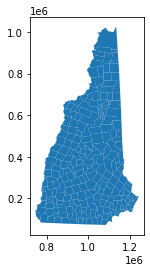

In [36]:
pb_poly.plot()

In [32]:
# Data check: Pittsburg area in sq ft and acres
p_name = pb_poly.loc[0, 'NAME']
pitts_sqft = pb_poly.loc[0, 'geometry'].area
conv_factor = 43560
print(f'{p_name} sq ft: {pitts_sqft}')
print(f'{p_name} acres: {pitts_sqft/conv_factor}')

Pittsburg sq ft: 8120912285.074219
Pittsburg acres: 186430.4932294357


In [37]:
# Import public and conservation land (pcl) data
pcl_path = '../../NH_PublicConservationLand/GRANIT_20220220154602/consnh.shp'

In [38]:
public = gpd.read_file(pcl_path, driver='shapefile')

In [44]:
public.head()

,SHAPE_Leng,SHAPE_Area,TID,NAME,NAMEALT,P_NAME,P_NAMEALT,PPTYPE,PPTERMTYPE,PPTERM,SPTYPE1,SPTYPE2,PPAGENCY,PPAGENTYPE,SPAGENCY1,SPAGENCY2,RSIZE,CSIZE,P_RSIZE,P_CSIZE,PROGRAM,LEVEL_,MSTATUS,SOURCE,ACCURACY,COBKPG,DATEREC1,DATEREC2,ACCESS,DATEADDED,DATEALTER,NOTES1,NOTES2,NOTES3,NOTES4,PID,GAP_STATUS,OWNERTYPE,geometry
0,83426.545022,2.163150e+08,006-004 -002,Connecticut Lakes WMA North (West),None,Connecticut Lakes Natural Area,Connecticut Lakes Headwaters,FO,P,-98,CE,CE,32000,3,52010,31000,-999.0,4965.930,25000.0,25001.000,7,1,3,NH DRED/SURVEY,1,07/1018/197,20021230,None,1,20050117,20170418,"Other Programs: LCHIP, N.A. Wetlands Conservat...",BOUNDARY ADJUSTED TO MEET 2009 DRED SURVEY CT ...,Boundary updated to match 006-001 -001,None,006-004 -,3,3,"POLYGON ((1099405.625 1002946.688, 1099033.625..."
1,61619.397201,4.721541e+07,006-004 -003,Connecticut Lakes WMA North (East),None,Connecticut Lakes Natural Area,Connecticut Lakes Headwaters,FO,P,-98,CE,CE,32000,3,52010,31000,-999.0,1083.920,25000.0,25001.000,7,1,3,NH DRED/SURVEY,1,07/1018/197,20021230,None,1,20050117,20170418,"Other Programs: LCHIP, N.A. Wetlands Conservat...",BOUNDARY ADJUSTED TO MEET 2009 DRED SURVEY CT ...,Boundary updated to match 006-001 -001,None,006-004 -,3,3,"POLYGON ((1108214.134 1000715.787, 1108214.125..."
2,22319.159084,4.695122e+06,006-001 -004,Connecticut Lakes State Forest,None,Connecticut Lakes State Forest,None,FO,U,-99,None,None,31000,3,0,0,-999.0,107.786,1531.0,1530.510,0,1,2,USGS,2,07/284/376,19351104,None,1,None,20170418,NH DRED,BOUNDARIES UPDATED WITH DATA SENT FROM NH F&G ...,Boundary and attributes updated by NH DRED,None,006-001 -,2,3,"POLYGON ((1102884.216 960520.713, 1102849.300 ..."
3,7552.234495,3.371443e+06,006-002 -001,Fourth Connecticut Lake Preserve,None,Fourth Connecticut Lake Preserve,None,FO,U,-99,None,None,52010,5,0,0,78.1,77.398,78.1,77.398,0,1,1,SURVEY,2,None,1990,None,1,None,20050117,BOUNDARIES UPDATED WITH DATA SENT FROM NH F&G,None,None,None,006-002 -,1,5,"POLYGON ((1101565.750 1002827.688, 1100987.125..."
4,31544.856081,1.836509e+07,006-003 -001,Norton Pool Preserve,None,Norton Pool Preserve,None,FO,U,-99,None,None,52010,5,0,0,-999.0,421.606,427.1,422.936,0,1,1,SURVEY,1,None,1986,None,1,None,None,1 OF 2 TRACTS,None,None,None,006-003 -,1,5,"POLYGON ((1126678.250 982401.250, 1126702.250 ..."


In [45]:
public.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 12591 entries, 0 to 12590
Data columns (total 39 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   SHAPE_Leng  12591 non-null  float64 
 1   SHAPE_Area  12591 non-null  float64 
 2   TID         12591 non-null  object  
 3   NAME        12591 non-null  object  
 4   NAMEALT     1110 non-null   object  
 5   P_NAME      12591 non-null  object  
 6   P_NAMEALT   336 non-null    object  
 7   PPTYPE      12591 non-null  object  
 8   PPTERMTYPE  12591 non-null  object  
 9   PPTERM      12591 non-null  int64   
 10  SPTYPE1     2460 non-null   object  
 11  SPTYPE2     290 non-null    object  
 12  PPAGENCY    12591 non-null  int64   
 13  PPAGENTYPE  12591 non-null  int64   
 14  SPAGENCY1   12591 non-null  int64   
 15  SPAGENCY2   12591 non-null  int64   
 16  RSIZE       12591 non-null  float64 
 17  CSIZE       12591 non-null  float64 
 18  P_RSIZE     12591 non-null  float64 
 

In [59]:
public.crs

<Derived Projected CRS: PROJCS["NAD83 / New Hampshire (ftUS)",GEOGCS["NAD8 ...>
Name: NAD83 / New Hampshire (ftUS)
Axis Info [cartesian]:
- [east]: Easting (US survey foot)
- [north]: Northing (US survey foot)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [47]:
# Counts by property type
public['PPTYPE'].value_counts()

FO    6506
CE    4936
SA     522
DR     234
FE     200
AR      73
SE      38
RW      29
PE      29
LE      12
HP       9
RV       3
Name: PPTYPE, dtype: int64

In [51]:
# Counts by primary protecting agency
"""
1 Municipal/County
2 Federal
3 State
4 Other Public/Quasi-Public Entity
5 Private
"""

public['PPAGENTYPE'].value_counts()

1    5612
5    4504
3    1461
2     767
4     247
Name: PPAGENTYPE, dtype: int64

In [48]:
# Counts by owner type
"""
1 Municipal
2 Federal
3 State
4 Other Public/Quasi-Public Entity
5 Private
6 County
9 Uknown
"""
public.groupby('OWNERTYPE').size()

OWNERTYPE
1    4135
2     413
3    1019
4     290
5    6660
6      47
9      27
dtype: int64

In [72]:
selt = public[public['PPAGENCY'] == 51960]
selt.tail(10)

,SHAPE_Leng,SHAPE_Area,TID,NAME,NAMEALT,P_NAME,P_NAMEALT,PPTYPE,PPTERMTYPE,PPTERM,SPTYPE1,SPTYPE2,PPAGENCY,PPAGENTYPE,SPAGENCY1,SPAGENCY2,RSIZE,CSIZE,P_RSIZE,P_CSIZE,PROGRAM,LEVEL_,MSTATUS,SOURCE,ACCURACY,COBKPG,DATEREC1,DATEREC2,ACCESS,DATEADDED,DATEALTER,NOTES1,NOTES2,NOTES3,NOTES4,PID,GAP_STATUS,OWNERTYPE,geometry
12578,9070.755872,2.173732e+06,185-163 -001,"Kaczmarek, E",None,"Kaczmarek, E",None,CE,P,-98,None,None,51960,5,0,0,49.9,49.90220,49.9,49.9022,0,1,4,SURVEY,1,15/5885/2660,20180110,None,3,20210630,None,None,None,None,None,185-163 -,4,5,"POLYGON ((1176538.785 162993.248, 1177010.035 ..."
12579,6101.768400,1.750995e+06,154-094 -001,Langley & Kennard Forest,None,Langley & Kennard Forest,None,FO,P,-98,CE,None,51960,5,22100,0,40.2,40.19750,40.2,40.1975,0,1,2,SURVEY,1,17/4571/310,20180529,None,1,20210630,None,PROGRAM: WRE,None,None,None,154-094 -,2,5,"POLYGON ((1158666.065 235092.653, 1158581.732 ..."
12580,8340.898027,3.257881e+06,168-043 -003,Candace Thayer,None,Lamprey River Wildlife Preserve,None,FO,P,-98,None,None,51960,5,0,0,75.0,74.79100,160.4,158.5890,0,1,2,SURVEY,1,15/6010/76 + 15/6010/79,20190620,None,1,20210630,None,None,None,None,None,168-043 -,2,5,"POLYGON ((1156678.095 204553.994, 1156681.132 ..."
12581,8404.754624,2.459180e+06,168-043 -002,Limperis,None,Lamprey River Wildlife Preserve,None,FO,P,-98,CE,EI,51960,5,22100,52800,58.1,56.45520,160.4,158.5890,10,1,1,SURVEY,1,15/5657/2871,20150929,None,1,None,20210630,None,PROGRAM:WRE,Candace Thayer added to the total parcel size,None,168-043 -,1,5,"POLYGON ((1154863.831 203934.892, 1154851.060 ..."
12582,6290.624674,1.191061e+06,168-043 -001,Suke,None,Lamprey River Wildlife Preserve,None,FO,P,-98,None,None,51960,5,0,0,27.3,27.34310,160.4,158.5890,99,1,2,SURVEY,1,15/4154/0463,20030919,None,1,20040120,20210630,PROGRAM: LAMPREY RIVER ADVISORY COMMITTEE,None,Candace Thayer added to the total parcel size,None,168-043 -,2,5,"POLYGON ((1155420.908 202203.907, 1155402.603 ..."
12583,5379.686554,1.455561e+06,168-128 -001,Mullen,None,Mullen,None,FO,P,-98,CE,None,51960,5,22100,0,33.4,33.41520,33.4,33.4152,0,1,2,SURVEY,1,15/6029/213 + 15/6029/20,20190823,None,1,20210630,None,None,None,None,None,168-128 -,2,5,"POLYGON ((1131175.674 184065.297, 1132215.111 ..."
12584,2032.739201,2.401403e+05,127-072 -001,Panish #2,FRPP,Panish #2,FRPP,CE,P,-98,EI,EI,51960,5,22100,40350,-999.0,5.51289,16.0,15.9537,0,1,4,SURVEY,1,17/3539/0337,20070614,None,3,20210630,None,None,None,None,None,127-072 -,4,5,"POLYGON ((1156148.549 344111.880, 1156026.030 ..."
12585,2695.447495,4.547987e+05,127-072 -002,Panish #2,FRPP,Panish #2,FRPP,CE,P,-98,EI,EI,51960,5,22100,40350,-999.0,10.44080,16.0,15.9537,0,1,4,SURVEY,1,17/3539/0337,20070614,None,3,20210630,None,None,None,None,None,127-072 -,4,5,"POLYGON ((1157340.852 344455.135, 1156938.664 ..."
12586,3298.117398,5.240291e+05,168-129 -001,Reinhold-Johnson,None,Reinhold-Johnson,None,FO,P,-98,None,None,51960,5,0,0,12.0,12.03010,12.0,12.0301,0,1,2,SURVEY,1,15/5968/1243,20181214,None,1,20210630,None,None,None,None,None,168-129 -,2,5,"POLYGON ((1153004.213 210804.186, 1153128.104 ..."
12587,3669.699044,7.235679e+05,141-012 -001,"Rochester #2, CIty of",Copper Lane,"Rochester #2, CIty of",Copper Lane,CE,P,-98,None,None,51960,5,0,0,16.6,16.61090,16.6,16.6109,0,1,2,SURVEY,1,17/4135/0784,20130610,None,1,19980804,20210630,"Was town land in GRANIT, now SELT holds CE.",None,None,None,141-012 -,2,1,"POLYGON ((1180740.348 302823.621, 1180873.284 ..."


<AxesSubplot:>

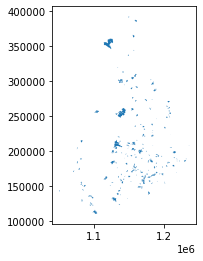

In [73]:
selt.plot()

In [78]:
# Create geojson for map
selt_geojson = selt.to_crs('epsg:4326').__geo_interface__

In [79]:
# Create a basemap
m_selt = geemap.Map(center=[43.78699687528447, -71.51658744025995],
                    zoom=8,
                    ee_initialize=False)

# Polygon style
style = {
    "stroke": True,
    "color": "#000000",
    "weight": 2,
    "opacity": 1,
    "fill": True,
    "fillColor": "#0000ff",
    "fillOpacity": 0.4,
}

m_selt

Map(center=[43.78699687528447, -71.51658744025995], controls=(WidgetControl(options=['position', 'transparent_…

In [80]:
m_selt.add_geojson(selt_geojson, layer_name="Southeast Land Trust")

## Create Town and County Boundaries

In [84]:
pb_poly['town_bounds'] = pb_poly.boundary

<AxesSubplot:>

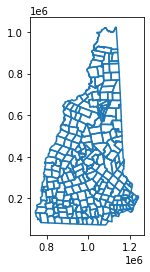

In [86]:
pb_poly.boundary.plot()

In [85]:
pb_poly.head()

,FIPS,NAME,RPA,ACRES,COUNTY,geometry,town_bounds
0,7160,Pittsburg,1,186430.5,7,"POLYGON ((1063158.250 1002584.875, 1063233.000...","LINESTRING (1063158.250 1002584.875, 1063233.0..."
1,7040,Clarksville,1,39915.8,7,"POLYGON ((1059756.000 928359.250, 1059898.250 ...","LINESTRING (1059756.000 928359.250, 1059898.25..."
2,7005,Atkinson & Gilmanton,1,12351.3,7,"POLYGON ((1111451.250 916720.625, 1111518.250 ...","LINESTRING (1111451.250 916720.625, 1111518.25..."
3,7190,Stewartstown,1,30019.1,7,"POLYGON ((1019728.688 911317.500, 1019769.188 ...","LINESTRING (1019728.688 911317.500, 1019769.18..."
4,7175,Second College,1,26773.9,7,"POLYGON ((1117369.750 895118.500, 1117506.500 ...","LINESTRING (1117369.750 895118.500, 1117506.50..."


In [116]:
# Create temporary GeoDataFrame for county info
counties = gpd.GeoDataFrame(pb_poly.groupby('COUNTY').size(),
                            columns=['num_towns'])
counties

,num_towns
COUNTY,
1,11
3,19
5,23
7,43
9,40
11,31
13,27
15,37
17,13


In [117]:
# Loop over pb_poly, group by county, combine polygons, calc boundary
for idx, row in counties.iterrows():
    counties.loc[idx, 'geometry'] = pb_poly[pb_poly['COUNTY'] == idx]['geometry'].unary_union

In [118]:
counties['boundary'] = counties['geometry'].boundary

In [119]:
counties

,num_towns,geometry,boundary
COUNTY,,,
1,11,"POLYGON ((1015148.688 347257.250, 1014901.375 ...","LINESTRING (1015148.688 347257.250, 1014901.37..."
3,19,"POLYGON ((1126799.250 391095.000, 1126683.000 ...","LINESTRING (1126799.250 391095.000, 1126683.00..."
5,23,"POLYGON ((834911.250 80684.172, 831492.125 808...","LINESTRING (834911.250 80684.172, 831492.125 8..."
7,43,"POLYGON ((1060894.500 610400.000, 1060746.250 ...","LINESTRING (1060894.500 610400.000, 1060746.25..."
9,40,"POLYGON ((929173.375 397185.125, 924505.500 39...","LINESTRING (929173.375 397185.125, 924505.500 ..."
11,31,"POLYGON ((974770.125 75048.172, 974622.500 750...","LINESTRING (974770.125 75048.172, 974622.500 7..."
13,27,"POLYGON ((983544.125 237690.438, 979663.375 23...","LINESTRING (983544.125 237690.438, 979663.375 ..."
15,37,"POLYGON ((1147664.000 118687.047, 1147544.000 ...","LINESTRING (1147664.000 118687.047, 1147544.00..."
17,13,"POLYGON ((1167108.250 212985.000, 1166733.250 ...","LINESTRING (1167108.250 212985.000, 1166733.25..."


<AxesSubplot:>

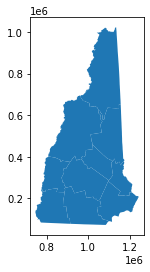

In [120]:
counties.plot()